<a href="https://colab.research.google.com/github/saeziae/UPF-NLP/blob/main/spamClassifier/spamClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import BERT

In [2]:
from transformers import TFBertModel

bert_model_name = 'bert-base-uncased'
bert_model = TFBertModel.from_pretrained(bert_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [3]:
max_len = 140

## Import data

In [5]:
src_texts = []
with open("SMSSpamCollection","r",encoding="utf-8") as f:
  src_texts = f.readlines()
  src_texts = list(map(lambda x:x.rstrip().split("\t",1),src_texts))


In [6]:
print(src_texts[:5])

[['ham', 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'], ['ham', 'Ok lar... Joking wif u oni...'], ['spam', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"], ['ham', 'U dun say so early hor... U c already then say...'], ['ham', "Nah I don't think he goes to usf, he lives around here though"]]


# Tokenisation

labels:

- ham - 0
- spam - 1

In [7]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

tokenized_texts = []
labels = []

for label, text in src_texts:
  tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors='tf')
  tokenized_texts.append(tokens['input_ids'])
  labels.append(1 if label == "spam" else 0)

print(tokenized_texts[0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tf.Tensor(
[[  101  2175  2127 18414 17583  2391  1010  4689  1012  1012  2800  2069
   1999 11829  2483  1050  2307  2088  2474  1041 28305  1012  1012  1012
  25022  2638  2045  2288 26297 28194  1012  1012  1012   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)


## The model

In [8]:
import tensorflow as tf

# Extract input_ids tensor from the provided dictionary and convert it to a KerasTensor
inputs = tf.keras.Input(shape=(1,max_len))
conv_layer = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(inputs)  # optimise with convolution
conv_layer = tf.keras.layers.BatchNormalization()(conv_layer)

lstm_outputs = tf.keras.layers.LSTM(64, return_sequences=True)(conv_layer)  # LSTM layer
lstm_outputs = tf.keras.layers.LSTM(32)(lstm_outputs)  # Another LSTM layer
dense_layer = tf.keras.layers.Dense(64, activation='relu')(lstm_outputs)  # non-linear is cool :)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)  # Output layer for binary classification
model = tf.keras.Model(inputs, outputs)

##Train

In [9]:
import numpy as np

# Convert lists to numpy arrays
tr_tokenized_texts = np.array(tokenized_texts[:4800])
tr_labels = np.array(labels[:4800])

# Decrase the lr as optimisation
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        return lr * 0.5
    else:
        return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(tr_tokenized_texts, tr_labels, epochs=100, batch_size=32, callbacks=[lr_callback])

Epoch 1/100
150/150 [==============================] - 7s 6ms/step - loss: 0.3119 - accuracy: 0.8906 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 1s 6ms/step - loss: 0.1998 - accuracy: 0.9196 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 1s 6ms/step - loss: 0.1775 - accuracy: 0.9304 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 1s 6ms/step - loss: 0.1696 - accuracy: 0.9350 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 1s 6ms/step - loss: 0.1497 - accuracy: 0.9452 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 1s 6ms/step - loss: 0.1441 - accuracy: 0.9488 - lr: 0.0010
Epoch 7/100
150/150 [==============================] - 1s 6ms/step - loss: 0.1350 - accuracy: 0.9481 - lr: 0.0010
Epoch 8/100
150/150 [==============================] - 1s 9ms/step - loss: 0.1196 - accuracy: 0.9590 - lr: 0.0010
Epoch 9/100
150/150 [==============================] - 1s 9ms/step - loss: 0.1134 - accu

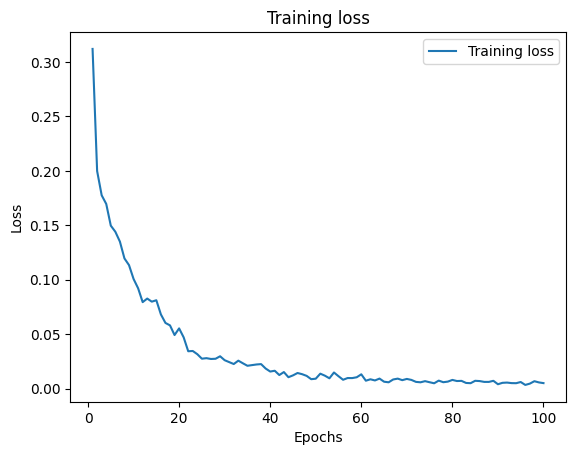

In [10]:
import matplotlib.pyplot as plt

# Get the loss history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plot the loss curve
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluation

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Convert lists to numpy arrays
ts_tokenized_texts = np.array(tokenized_texts[4800:])
ts_labels = np.array(labels[4800:])


# Evaluate on the testing set
ts_preds = model.predict(ts_tokenized_texts)  # Get predictions on testing data
ts_preds = (ts_preds > 0.5).astype(int)  # Convert probabilities to class labels (spam=1, ham=0)

accuracy = accuracy_score(ts_labels, ts_preds)
precision = precision_score(ts_labels, ts_preds)
recall = recall_score(ts_labels, ts_preds)
f1 = f1_score(ts_labels, ts_preds)

recall_no_spam = recall_score(ts_labels, ts_preds, pos_label=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Good msg Recall:", recall_no_spam)
print("F1-score:", f1)

25/25 [==============================] - 0s 4ms/step
Accuracy: 0.9444444444444444
Precision: 0.8452380952380952
Recall: 0.7029702970297029
Good msg Recall: 0.9806835066864784
F1-score: 0.7675675675675676


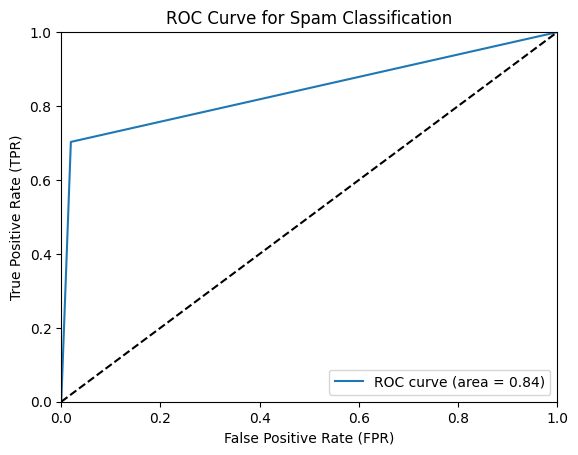

In [12]:
from sklearn.metrics import roc_curve, auc

# Get actual labels and predicted probabilities from your testing data

fpr, tpr, thresholds = roc_curve(ts_labels, ts_preds)  # Calculate ROC curve metrics
roc_auc = auc(fpr, tpr)  # Calculate Area Under the Curve (AUC)

# Plot the ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot baseline (random classification)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Spam Classification')
plt.legend(loc="lower right")
plt.show()